In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip show torch


Name: torch
Version: 1.12.1.post201
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/duyanh/anaconda3/envs/jupiter/lib/python3.10/site-packages
Requires: typing_extensions
Required-by: torchaudio, torchvision


In [3]:
!nvidia-smi

Mon Mar  6 17:56:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   39C    P8    11W /  90W |     22MiB /  2000MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import math 
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Use CUDA

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Replay Buffer

In [7]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state,done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))
        
    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)

    def __len__(self):
        return len(self.buffer)


# Bit Flipping Environment


In [8]:
class Env(object):
    def __init__(self, num_bits):
        self.num_bits = num_bits

    def reset(self):
        self.done = False
        self.num_steps = 0
        self.state = np.random.randint(2, size=self.num_bits)
        self.target = np.random.randint(2, size=self.num_bits)
        return self.state, self.target

    def step(self, action):
        if self.done:
            raise RESET

        self.state[action] = 1 - self.state[action]

        if self.num_steps > self.num_bits + 1:
            self.done = True
        self.num_steps += 1

        if np.sum(self.state == self.target) == self.num_bits:
            self.done = True
            return np.copy(self.state), 0, self.done, {}
        else:
            return np.copy(self.state), -1, self.done, {}


# Neural Network


In [9]:
class Model(nn.Module):
    def __init__(self, num_imputs, num_outputs, hidden_size=256) -> None:
        super(Model, self).__init__()
        self.linear1 = nn.Linear(num_imputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    
    def forward(self, state, goal):
        x = torch.cat([state, goal], 1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
def update_target(current_model, target_module):
    target_module.load_state_dict(current_model.state_dict())

In [10]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1: 
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    return q_value.argmax()
       

In [11]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('Mean Reward: %s. frame: %s' % (rewards[-1], frame_idx))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


# Q-learning TD Error

In [12]:
def compute_td_error(batch_size):
    if batch_size > len(replay_buffer):
        return None

    state, action, reward, next_state, done, goal = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(state).to(device)
    reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
    action = torch.LongTensor(action).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    goal = torch.FloatTensor(goal).to(device)
    mask = torch.FloatTensor(1 - np.float32(done)).unsqueeze(1).to(device)

    q_values = model(state, goal)
    q_value = q_values.gather(1, action)

    next_q_values = target_model(next_state, goal)
    target_action = next_q_values.max(1)[1].unsqueeze(1)
    next_q_value = target_model(next_state, goal).gather(1, target_action)

    expected_q_value = reward + 0.99 * next_q_value * mask

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


# Hindsight Experienc Replay

In [13]:
num_bits = 11
env = Env(num_bits)

model = Model(2*num_bits, num_bits).to(device)
target_model = Model(2*num_bits, num_bits).to(device)
update_target = (model, target_model)

#Hyperparams:
batch_size = 5
new_goals = 5
max_frames = 2000000

optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

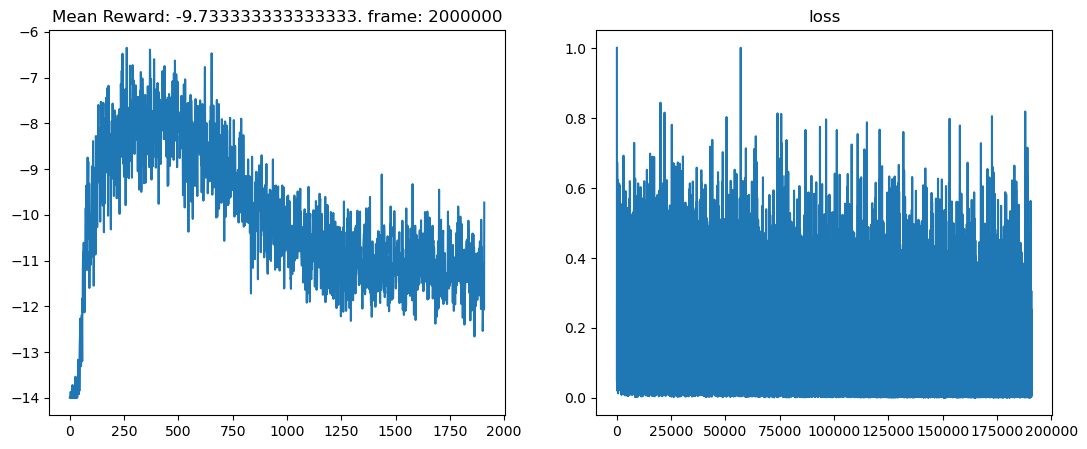

In [14]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state, goal = env.reset()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        episode.append((state,reward, done, next_state, goal))
        replay_buffer.push(state, action, reward, next_state,done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) 
                    for i in range(0, len(all_rewards), 100)], losses)
    all_rewards.append(total_reward)

    
    new_episode = []
    for state, reward, done, next_state, goal in episode:
        for t in np.random.choice(num_bits, new_goals):
            try:
                episode[t]
            except:
                continue
            new_goal = episode[t][-2]
            if np.sum(next_state == new_goal) == num_bits:
                reward = 0
            else:
                reward = -1
            replay_buffer.push(state,action, reward, next_state, done, new_goal)
            new_episode.append((state, reward, done, next_state, new_goal))
        
    loss = compute_td_error(batch_size)
    if loss is not None:
        losses.append(loss.cpu().data.numpy())
        

# DQN without Hindsight Experience Replay

In [15]:
num_bits = 11
env = Env(num_bits)

model = Model(2*num_bits, num_bits).to(device)
target_model = Model(2*num_bits, num_bits).to(device)
update_target(model, target_model)

#hyperparam:
batch_size = 5
new_goal = 5
max_frames = 200000

optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

TypeError: 'tuple' object is not callable

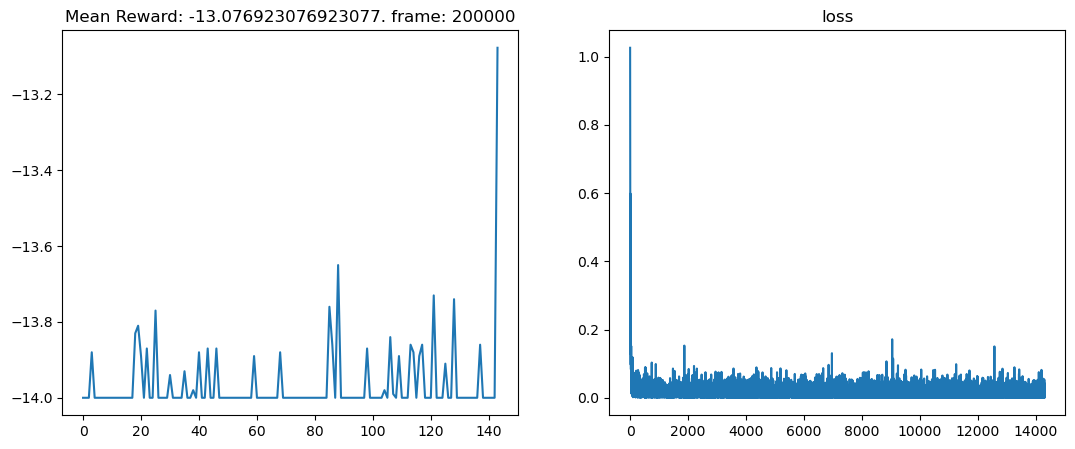

In [ ]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state, goal = env.reset()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100])
                 for i in range(0, len(all_rewards), 100)], losses)
        
    all_rewards.append(total_reward)
    
    loss = compute_td_error(batch_size)
    if loss is not None: losses.append(loss.cpu().data.numpy())